In [2]:
# !pip install evaluate transformers accelerate -U # torch

In [3]:
# ! pip install -U accelerate
# ! pip install -U transformers

In [4]:
from huggingface_hub import notebook_login

notebook_login()

In [5]:
import transformers
import torch

print(transformers.__version__)

4.40.0


In [6]:
model_checkpoint = "t5-small"

In [7]:
if model_checkpoint in ["t5-small", "t5-base", "t5-larg", "t5-3b", "t5-11b"]:
    prefix = 'code sql query: ' # "summarize: "
else:
    prefix = ""

## loading the dataset

In [8]:
import pandas as pd

df = pd.read_csv(r'/content/text-to-sql_from_spider.csv')

In [9]:
df

,spider_db_name,sql,question,schema
0,department_management,select count ( * ) from head where age > 56,How many heads of the departments are older th...,"| department : department_id , name , creation..."
1,department_management,"select name , born_state , age from head order...","List the name, born state and age of the heads...","| department : department_id , name , creation..."
2,department_management,"select creation , name , budget_in_billions fr...","List the creation year, name and budget of eac...","| department : department_id , name , creation..."
3,department_management,"select max ( budget_in_billions ) , min ( budg...",What are the maximum and minimum budget of the...,"| department : department_id , name , creation..."
4,department_management,select avg ( num_employees ) from department w...,What is the average number of employees of the...,"| department : department_id , name , creation..."
...,...,...,...,...
6995,culture_company,select culture_company.company_name from cultu...,What are all the company names that have a boo...,"| book_club : book_club_id , year , author_or_..."
6996,culture_company,"select movie.title , book_club.book_title from...",Show the movie titles and book titles for all ...,"| book_club : book_club_id , year , author_or_..."
6997,culture_company,"select movie.title , book_club.book_title from...",What are the titles of movies and books corres...,"| book_club : book_club_id , year , author_or_..."
6998,culture_company,select culture_company.company_name from movie...,Show all company names with a movie directed i...,"| book_club : book_club_id , year , author_or_..."


### creating input and output data

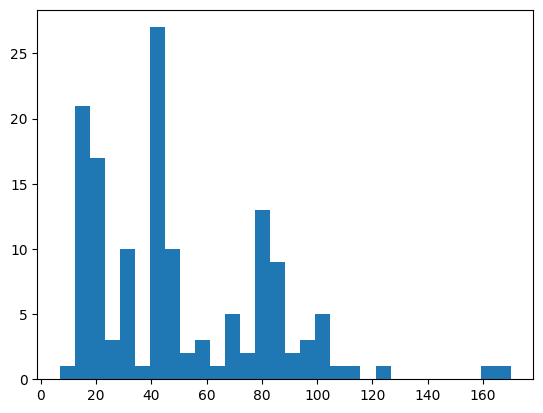

In [10]:
from matplotlib import pyplot as plt

db_frequency = df.spider_db_name.value_counts()
plt.hist(db_frequency.values, 30)
plt.show()

In [11]:
df_new = pd.DataFrame()

# df_new['db_weight'] = 1 / (db_frequency[df['spider_db_name']].values ** 0.5)
df_new['input'] = 'schema: ' + df['schema'] + ' question: ' + df['question']
df_new['output'] = df['sql']
df_new

,input,output
0,"schema: | department : department_id , name , ...",select count ( * ) from head where age > 56
1,"schema: | department : department_id , name , ...","select name , born_state , age from head order..."
2,"schema: | department : department_id , name , ...","select creation , name , budget_in_billions fr..."
3,"schema: | department : department_id , name , ...","select max ( budget_in_billions ) , min ( budg..."
4,"schema: | department : department_id , name , ...",select avg ( num_employees ) from department w...
...,...,...
6995,"schema: | book_club : book_club_id , year , au...",select culture_company.company_name from cultu...
6996,"schema: | book_club : book_club_id , year , au...","select movie.title , book_club.book_title from..."
6997,"schema: | book_club : book_club_id , year , au...","select movie.title , book_club.book_title from..."
6998,"schema: | book_club : book_club_id , year , au...",select culture_company.company_name from movie...


In [12]:
df_new.loc[0, 'input']

'schema: | department : department_id , name , creation , ranking , budget_in_billions , num_employees | head : head_id , name , born_state , age | management : department_id , head_id , temporary_acting | management.head_id = head.head_id | management.department_id = department.department_id | question: How many heads of the departments are older than 56 ?'

### train / val split

In [13]:
from sklearn.model_selection import train_test_split

train_df, val_df = train_test_split(df_new, test_size=0.1, random_state=42)
train_df.shape, val_df.shape

((6300, 2), (700, 2))

## Loading the metric

This is not an ideal metric for text to sql. A better evaluation would be to run the queries see how many of them run at all + syntactic correctness, how many give the exact table that we wanted and compare the execution times (complexity) with the original query. However for simplicity i'll just go with SacreBLEU

In [ ]:
!pip install sacrebleu
from datasets import load_metric

# Load the SacreBLEU metric
metric = load_metric("sacrebleu")

input_sentence = "The quick brown fox jumps over the lazy dog."
output_sentence = "The quick brown dog jumps over the lazy fox."

# Calculate the WER
metric.compute(predictions=[output_sentence], references=[[input_sentence]])

## Tokenize the data

In [15]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [16]:
print(tokenizer(text_target=["Hello, this one sentence!", "This is another sentence."]))

{'input_ids': [[8774, 6, 48, 80, 7142, 55, 1], [100, 19, 430, 7142, 5, 1]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1]]}


In [17]:
import inspect
inspect.signature(tokenizer)

<Signature (text: Union[str, List[str], List[List[str]]] = None, text_pair: Union[str, List[str], List[List[str]], NoneType] = None, text_target: Union[str, List[str], List[List[str]]] = None, text_pair_target: Union[str, List[str], List[List[str]], NoneType] = None, add_special_tokens: bool = True, padding: Union[bool, str, transformers.utils.generic.PaddingStrategy] = False, truncation: Union[bool, str, transformers.tokenization_utils_base.TruncationStrategy] = None, max_length: Optional[int] = None, stride: int = 0, is_split_into_words: bool = False, pad_to_multiple_of: Optional[int] = None, return_tensors: Union[str, transformers.utils.generic.TensorType, NoneType] = None, return_token_type_ids: Optional[bool] = None, return_attention_mask: Optional[bool] = None, return_overflowing_tokens: bool = False, return_special_tokens_mask: bool = False, return_offsets_mapping: bool = False, return_length: bool = False, verbose: bool = True, **kwargs) -> transformers.tokenization_utils_base.

In [18]:
max_input_length = 1024
max_target_length = 128

def preprocess_function(df_):
    inputs = list((prefix + df_['input']).values)
    model_inputs = tokenizer(inputs, max_length=max_input_length, truncation=True) #, padding=True)

    # Setup the tokenizer for targets
    labels = tokenizer(text_target=list(df_['output'].values), max_length=max_target_length, truncation=True) #, padding=True)

    model_inputs["labels"] = labels["input_ids"]

    #model_inputs = dict([ [ k, torch.tensor(v)] for k, v in model_inputs.items()])
    return model_inputs

In [19]:
preprocess_function(df_new[:2])

{'input_ids': [[1081, 11820, 40, 11417, 10, 26622, 10, 1820, 3066, 3, 10, 3066, 834, 23, 26, 3, 6, 564, 3, 6, 3409, 3, 6, 11592, 3, 6, 1487, 834, 77, 834, 115, 14916, 7, 3, 6, 3, 5525, 834, 15, 51, 7379, 63, 15, 15, 7, 1820, 819, 3, 10, 819, 834, 23, 26, 3, 6, 564, 3, 6, 2170, 834, 5540, 3, 6, 1246, 1820, 758, 3, 10, 3066, 834, 23, 26, 3, 6, 819, 834, 23, 26, 3, 6, 7234, 834, 2708, 53, 1820, 758, 5, 3313, 834, 23, 26, 3274, 819, 5, 3313, 834, 23, 26, 1820, 758, 5, 221, 2274, 297, 834, 23, 26, 3274, 3066, 5, 221, 2274, 297, 834, 23, 26, 1820, 822, 10, 571, 186, 7701, 13, 8, 10521, 33, 2749, 145, 11526, 3, 58, 1], [1081, 11820, 40, 11417, 10, 26622, 10, 1820, 3066, 3, 10, 3066, 834, 23, 26, 3, 6, 564, 3, 6, 3409, 3, 6, 11592, 3, 6, 1487, 834, 77, 834, 115, 14916, 7, 3, 6, 3, 5525, 834, 15, 51, 7379, 63, 15, 15, 7, 1820, 819, 3, 10, 819, 834, 23, 26, 3, 6, 564, 3, 6, 2170, 834, 5540, 3, 6, 1246, 1820, 758, 3, 10, 3066, 834, 23, 26, 3, 6, 819, 834, 23, 26, 3, 6, 7234, 834, 2708, 53, 1820, 

In [20]:
tokenized_train = preprocess_function(train_df)
tokenized_val = preprocess_function(val_df)

In [21]:
from datasets import Dataset

tokenized_train_1 = Dataset.from_dict(tokenized_train)
tokenized_val_1 = Dataset.from_dict(tokenized_val)

## Fine-tuning the model

In [22]:
from transformers import AutoModelForSeq2SeqLM, DataCollatorForSeq2Seq, Seq2SeqTrainingArguments, Seq2SeqTrainer

model = AutoModelForSeq2SeqLM.from_pretrained(model_checkpoint)

In [23]:
batch_size = 16
model_name = model_checkpoint.split("/")[-1]
args = Seq2SeqTrainingArguments(
    f"{model_name}-finetuned-sql",
    evaluation_strategy = "epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    weight_decay=0.01,
    save_total_limit=3,
    num_train_epochs=1,
    predict_with_generate=True,
    fp16=True,
    # push_to_hub=True,
)

In [24]:
data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

In [25]:
import nltk
import numpy as np

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)
    # Replace -100 in the labels as we can't decode them.
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    # Rouge expects a newline after each sentence
    decoded_preds = ["\n".join(nltk.sent_tokenize(pred.strip())) for pred in decoded_preds]
    decoded_labels = [["\n".join(nltk.sent_tokenize(label.strip()))] for label in decoded_labels]
    print(decoded_preds)
    print()
    print(decoded_labels)

    # Note that other metrics may not have a `use_aggregator` parameter
    # and thus will return a list, computing a metric for each sentence.
    result = metric.compute(predictions=decoded_preds, references=decoded_labels) #, use_stemmer=True, use_aggregator=True)

    # Add mean generated length
    prediction_lens = [np.count_nonzero(pred != tokenizer.pad_token_id) for pred in predictions]
    result["gen_len"] = np.mean(prediction_lens)
    orig_lens = [np.count_nonzero(lbl != tokenizer.pad_token_id) for lbl in labels]
    result["orig_len"] = np.mean(orig_lens)

    result = {k: np.mean(v) for k, v in result.items() if k not in ['sys_len', 'ref_len']}
    return result

In [26]:
p = ['select names from scientists', 'select payment.date from payment join payment on payment.payment.payment.payment.payment.', 'select company.company_id from company where gas_station.station_id =',]
r = [['select count ( * ), scientists.name from scientists join assignedto on scientists.ssn = assignedto.scientist group by scientists.name'], ["select payment_date from payment where amount > 10 union select payment.payment_date from payment join staff on payment.staff_id = staff.staff_id where staff.first_name = 'Elsa'"], ['select company.company, count ( * ) from station_company join company on station_company.company_id = company.company_id group by station_company.company_id']]
metric.compute(predictions=p, references=r)

{'score': 6.8194853145471015,
 'counts': [33, 17, 10, 4],
 'totals': [40, 37, 34, 31],
 'precisions': [82.5,
  45.945945945945944,
  29.41176470588235,
  12.903225806451612],
 'bp': 0.19691167520419406,
 'sys_len': 40,
 'ref_len': 105}

Then we just need to pass all of this along with our datasets to the `Seq2SeqTrainer`:

In [27]:
trainer = Seq2SeqTrainer(
    model,
    args,
    train_dataset=tokenized_train_1,
    eval_dataset=tokenized_val_1,
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

We can now finetune our model by just calling the `train` method:

In [28]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [29]:
for _ in range(5):
  trainer.train()

Epoch,Training Loss,Validation Loss,Score,Counts,Totals,Precisions,Bp,Gen Len,Orig Len
1,No log,1.825731,7.142593,2131.750000,7309.000000,27.547270,0.307731,15.307143,35.257143


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1141: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


['select names from scientists', 'select payment_date from payment.customer_id from payment.customer_i', 'which gas stations', 'select actor.musical_id from musical', 'select select staff from project_staff.role_code from project_staff.project_', 'select salary from employees with salary between 8000 and 12000 for which commission is not null', 'select select faculty from faculty from faculty from faculty', 'select countries with more than one roller coaster', 'select school_bus.driver_id from school_bus.driver_i', 'select product_name from product_categories', 'select select bike_name from station', 'document_name, document_name, document_description, other_de', 'club.clubid = club.clubid', 'select support_rate from candidates', 'select city_code from dorm', 'select select department from enroll.stu_num from enroll.stu_num', 'select select student from student', 'Count the number of entrepreneurs', 'select location from cinema.cinema_id', 'select race.track_id from race', 'select sele

Epoch,Training Loss,Validation Loss,Score,Counts,Totals,Precisions,Bp,Gen Len,Orig Len
1,No log,1.180619,12.760177,3146.250000,8484.000000,35.547328,0.403706,16.802857,35.257143


['select names from scientists', 'select payment.date from payment join payment on payment.payment.payment.payment.payment.', 'select company.company_id from company where gas_station.station_id =', 'select musical_id from musical where musical_id = nominee, select musical_', 'select select staff.role_code from project_staff join project_staff on project_', 'select salary from employees where commission_pct = 8000 to 12000', 'select select lname from faculty join faculty on faculty.facid = faculty.f', 'select country.country_id from roller_coaster join country on roller_coaster', "select type from school where type ='school'", "select product_name from products where unit_of_measure = 'Handful'", 'select name from station where select name from station where select name from station where select name from station', 'select document_name from documents where document_name = BK', "select club.stuid from club where student.sex ='maj", 'select support_rate from candidate where support_rate

Epoch,Training Loss,Validation Loss,Score,Counts,Totals,Precisions,Bp,Gen Len,Orig Len
1,No log,0.918637,15.285501,3584.250000,8649.000000,39.971308,0.417018,17.272857,35.257143


['select names from scientists join projects on projects.code = projects.code where projects.name =', 'select payment.date from payment join staff on payment.staff_id = staff.staff', "select company.company_id from company where company.company_id = '", "select nominee from musical where category = 'Best'", 'select count ( * ) from staff join project_staff on project_staff.project_', 'select salary from employees join employees on employees.employee_id =', 'select facid from faculty join faculty on faculty.facid = faculty.facid', 'select country.country_id from roller_coaster join country on country.country_', "select type from school where type ='school'", "select product_name from products where color_code = 'Handful'", 'select station.name from station where bike_available = 7', "select document_name from documents where document_name = 'BK'", "select club.sex from club where lname = 'M'", "select support_rate from candidate where support_rate = '3'", 'select dorm.dormid from studen

Epoch,Training Loss,Validation Loss,Score,Counts,Totals,Precisions,Bp,Gen Len,Orig Len
1,No log,0.786620,16.822963,3916.500000,8457.000000,44.816075,0.401525,16.877143,35.257143


['select names from scientists join projects on scientists.ssn = projects.code where projects.', 'select payment.date from payment join staff on payment.staff_id = staff.staff', "select company.company_id from company where company.company_id = '", "select nominee from musical where category = 'Music'", 'select count ( * ) from project_staff join project_staff on project_staff.', 'select salary from employees where commission_pct = 8000 to 12000', 'select count ( * ) from faculty', 'select country.country_id from roller_coaster join country on country.country_', "select type from school where type ='school'", "select product_name from products where color_code = 'Handful'", 'select station.name from station where bike_available = 7', 'select document_name from documents join documents on documents.document_id = documents.document', "select club.clubname from member_of_club where club.sex = '", "select top 3 support_rate from candidate where support_rate = 'Support_", 'select dorm.city 

Epoch,Training Loss,Validation Loss,Score,Counts,Totals,Precisions,Bp,Gen Len,Orig Len
1,No log,0.697412,17.507876,4113.500000,8161.000000,48.896579,0.377591,16.344286,35.257143


['select names from scientists', 'select payment.date from payment join staff on payment.staff_id = staff.staff', 'select company.company_id from company join station_company on company.company_i', "select nominee from musical where category = 'Music'", 'select count ( * ) from project_staff join project_staff on project_staff.', 'select salary from employees where commission_pct = 8000 to 12000', 'select count ( * ) from faculty', 'select country.name from roller_coaster join country on roller_coaster.country_', "select type from school where type ='school' and type = 'bus'", "select product_name from products where color_code = 'Handful'", 'select station.name from station where bike_available = 7', "select document_name from documents where document_name = 'BK'", "select club.clubname from club where club.sex = 'Fname'", "select top 3 support_rate from candidate where support_rate = 'Support'", "select city_code from student where major, major = 'Stuid", 'select department.dept_name

# logging in with write token and saving the model

In [50]:
from huggingface_hub import notebook_login

notebook_login()

In [51]:
from transformers import T5ForConditionalGeneration, T5Tokenizer
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

model_name = "Movg/t5-small-finetuned-sql"

# Push the model to the Hugging Face model hub
model.push_to_hub(model_name)
tokenizer.push_to_hub(model_name)

model.safetensors:   0%|          | 0.00/242M [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/Movg/t5-small-finetuned-sql/commit/e89d1566d00aaba18392d17b7fada61a20993d04', commit_message='Upload tokenizer', commit_description='', oid='e89d1566d00aaba18392d17b7fada61a20993d04', pr_url=None, pr_revision=None, pr_num=None)